In [1]:
import json

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns

# Идентификация личности по голосу

Целью моей работы является построение модели, которая сможет отвечать на два последовательных вопроса: зарегистрирован ли человек в системе и что это за человек.

Для этого необходимо:
- собрать данные
- извлечь признаки
- построить модель

### Сбор данных

В своей работе я использовал открытый датасет dusha, содержащий множество голосовых эмоций от разных людей (https://developers.sber.ru/portal/products/dusha)
<br>
После удаления дубликатов по тексту говорящего, взятая часть датасета (crowd_train) содержала в себе 124 569 записей. Удалённые строки при тщательной проверка и правда оказались дубликатами.

Данные строки содержали в себе сообщения от 1806 различных пользователей. Очевидно, что данное количество слишком велико. Кроме того, количество аудиозаписей от разных пользователей колеблется от 1 до 500 на одного человека. Чтобы избежать проблемы дизбаланса классов, я использую функцию, ограничивающее количество человек в выборке и берущее для всех классов одинаковое количество сообщений (обычно это 5, для сравнения ниже рассмотрены случаи с 10 строками на человека)

### Извлечение признаков

Для извлечения признаков я использую такие алгоритмы как построение хромограммы, мел-спектрограммы, получение мел-кепстральных коэффициентов, тональных центров тяжести. 
Подробно алгоритм для получения мел-кепстральных коэффициентов, которые являются наиболее значимыми признаками, а следовательно и лучшей характеристикой аудиосигнала, разобран в файле mfcc_algorithm.ipynb в папке mfcc_alg

### Построение модели

Первоначальная идея состояла в выделении кластеров на основе признаков из аудиосообщений. На практике, все алгоритмы кластеризации требуют большое количество данных в кластере, что не подходит под бизнес задачу работы, ведь ни один человек не согласиться записывать по 350 голосовых сообщений, для добавления его голоса в базу данных. 

В основном, я использовал небольшую подвыборку из датасета, призванную симулировать реальные условия применения данной модели. Я решил действовать в рамках пяти голосовых сообщений на одного пользователя. Также пробовал по 350 объектов на один класс с малым количеством классов, что всё равно не смогло обеспечить достойного результата.

Конечным подходом, позволившим получить наилучший результат, стала построение модели-классификатора.

Все модели я логировал с помощью mlflow, что сильно облегчило сравнение моделей в процессе их подбора.

## Первый подход: обучение без учителя, кластеризация голосов

## Модели с заранее известным количеством кластеров, 102 класса, 5 аудиозаписей на каждый класс

In [2]:
experiment_name = "clusterization, 102 classes, 5 per class"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    'experiment_id']
clust_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=['metrics.f1_weighted'])
clust_102_5_df = clust_102_5_df.iloc[::-1][
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
    ]
]
clust_102_5_df = pd.melt(
    clust_102_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.f1_weighted', 'metrics.f1_micro', 'metrics.accuracy'],
    var_name='Metric',
    value_name='Value',
)

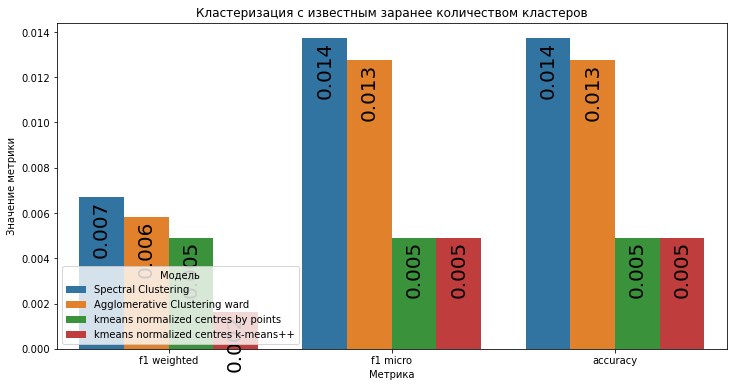

In [3]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value', hue='tags.mlflow.runName', data=clust_102_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['f1 weighted', 'f1 micro', 'accuracy'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
plt.legend(title='Модель', loc='lower left')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
bar.set_title('Кластеризация с известным заранее количеством кластеров')
plt.show()

KMeans с указанием начальных точек кластеров как одна из точек, принадлежащих этому классу имеет качетсво выше, вем у k-means++ инициализации, но всё равно очень низкое

Как видно, построенные модели имеют ужасное качество кластеризации. С неизвестным количеством кластеров дела состоят ещё хуже, а ещё число кластеров не совпадает с исходным числом в данных для обучения, из-за чего использование f1 метрики невозможно из-за съехавших меток классов. Здесь используется скорректированный индекс Rand как метрика.

## Модели с заранее неизвестным количеством кластеров

In [4]:
experiment_name = "clusterization without the number of classes, 102 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    'experiment_id']
clust_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=['metrics.adjusted_rand_score']
)
clust_102_5_df = clust_102_5_df.iloc[::-1][
    ['tags.mlflow.runName', 'metrics.adjusted_rand_score']
]
clust_102_5_df = pd.melt(
    clust_102_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.adjusted_rand_score'],
    var_name='Metric',
    value_name='Value',
)

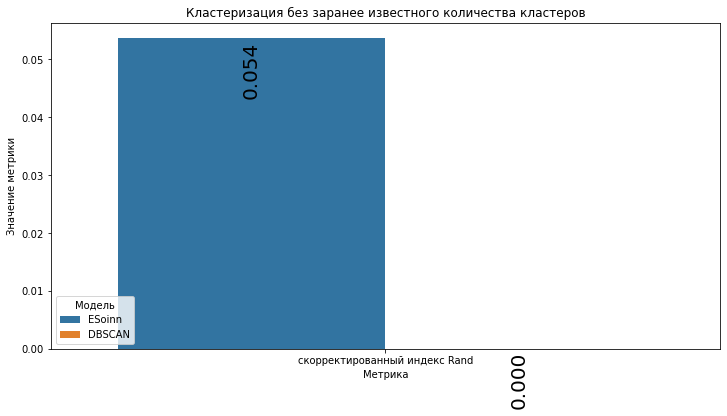

In [5]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value', hue='tags.mlflow.runName', data=clust_102_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['скорректированный индекс Rand'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
plt.legend(title='Модель', loc='lower left')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
bar.set_title('Кластеризация без заранее известного количества кластеров')
plt.show()

DBScan вообще не может выделить кластеры, а ESoinn хоть и выделяет чуть больше, чем 102 кластера, но они не соответсвуют исходным меткам в датасете

## Следующий подход: обучение с учителем, классификация голосов

Всего я использовал 4 разных набора данных: 
- по количеству классов
    - 102
    - 354
- по извлекаемым из аудио признакам
    - мел-кепстральные коэффициенты (метод описан ранее)
    - хромограмма, мел-спектрограмма, мел-кепстральные коэффициенты, тональные центры тяжести (методы не описаны в работе)

# Сначала рассмотрю модели, обученные только на мел-кепстральные коэффициентах

# Классификация на 102 класса

В задачи классификации были выдвинуты те же ограничения, а именно 5 объектов каждого класса на обучающей выборке.

Было проверено большое количество моделей, параметры которых подбирались как с помощью поиска по сетке, так и с помощью библиотеки optuna для более тяжеловесных моделей

In [6]:
experiment_name = "only mfcc 102 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    'experiment_id']
cls_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=['metrics.f1_weighted'])
cls_102_5_df = cls_102_5_df.iloc[::-1][
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
    ]
]
cls_102_5_df = pd.melt(
    cls_102_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.f1_weighted', 'metrics.f1_micro', 'metrics.accuracy'],
    var_name='Metric',
    value_name='Value',
)

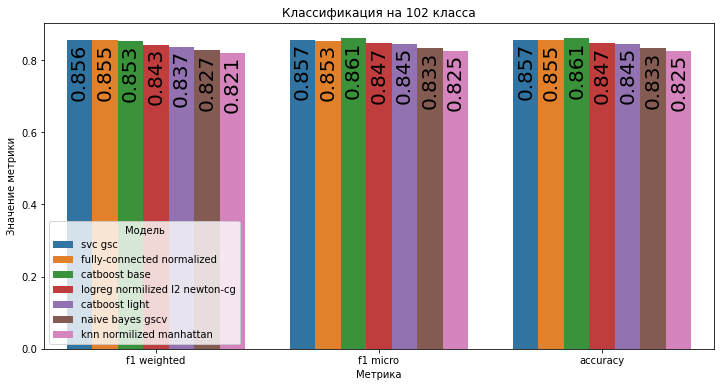

In [7]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value', hue='tags.mlflow.runName', data=cls_102_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['f1 weighted', 'f1 micro', 'accuracy'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
plt.legend(title='Модель', loc='lower left')
bar.set_title('Классификация на 102 класса')
plt.show()

### Как видно из представленных выше графиков, лучше всего себя показывают метод опорных векторов, полносвязная нейронная сеть и градиентный бустинг. 
### Сравню эти модели по времени обучения

In [8]:
cls_102_5_df = mlflow.search_runs([experiment_id], order_by=['metrics.f1_weighted'])
best_models = cls_102_5_df[
    cls_102_5_df['tags.mlflow.runName'].isin(
        ['catboost base', 'fully-connected normalized', 'svc gsc']
    )
]
best_models['training_time'] = (
    best_models['end_time'] - best_models['start_time']
).dt.seconds
best_models = best_models[
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
        'training_time',
    ]
]

C:\Users\Никита\AppData\Local\Temp\ipykernel_18304\4081326634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['training_time'] = (


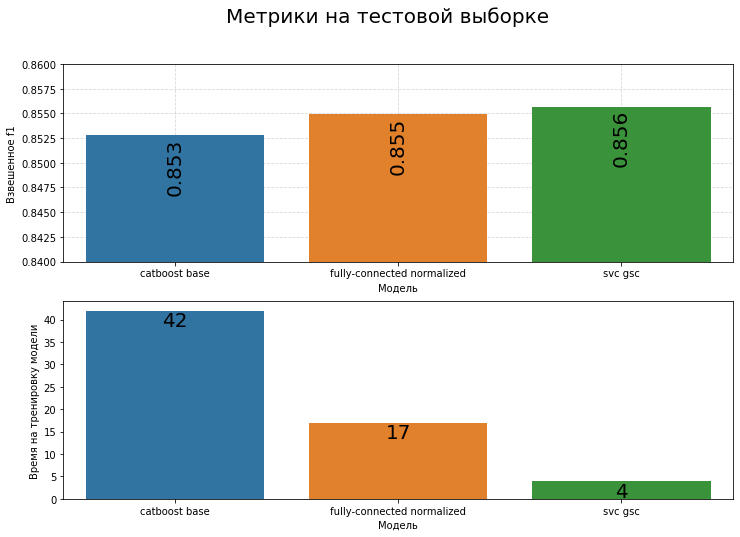

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.84, 0.86)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]), y="training_time", data=best_models
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Наглядно видно, что метод опорных векторов показал себя здесь лучше всего, начиная от качества, заканчивая временем, требуемым для обучения модели.

In [10]:
with open("cross_validation_scores/svc gsc.json", "r") as f:
    cv_scores = json.load(f)

svc_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])


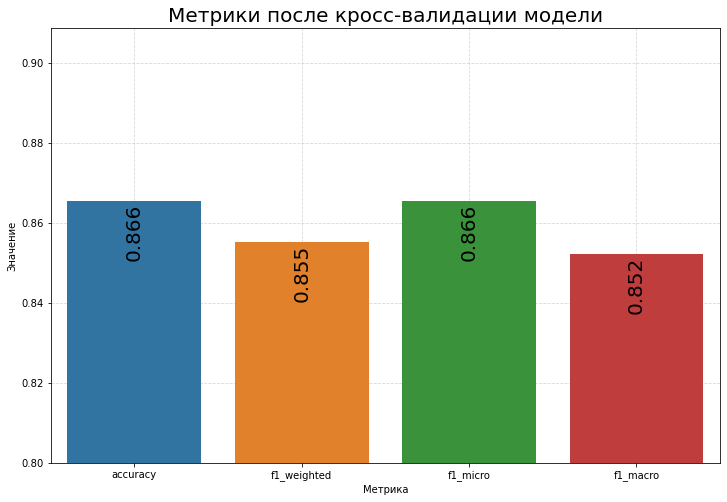

In [11]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=svc_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.8)
plt.show()


Значение метрик на кросс-валидации остались теми же, что говорит об отсутствии переобучения, путём подбора гиперпараметров

# Классификация на 354 класса

увеличив количество классов, оставив при этом количество данных на класс равным пяти, предсказательные возможности модели, конечно же, станут ниже.

In [12]:
experiment_name = "only mfcc 354 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    'experiment_id']
cls_354_5_df = mlflow.search_runs(
    [experiment_id], order_by=['metrics.f1_weighted'])
cls_354_5_df = cls_354_5_df.iloc[::-1][
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
    ]
]
cls_354_5_df = pd.melt(
    cls_354_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.f1_weighted', 'metrics.f1_micro', 'metrics.accuracy'],
    var_name='Metric',
    value_name='Value',
)

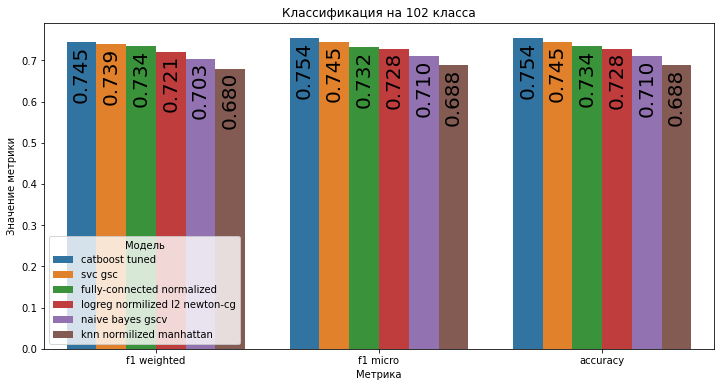

In [13]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value',
                  hue='tags.mlflow.runName', data=cls_354_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['f1 weighted', 'f1 micro', 'accuracy'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
plt.legend(title='Модель', loc='lower left')
bar.set_title('Классификация на 102 класса')
plt.show()

Сравню время, требуемое для обучения лучших моделей

In [14]:
cls_354_5_df = mlflow.search_runs([experiment_id], order_by=['metrics.f1_weighted'])
best_models = cls_354_5_df[
    cls_354_5_df['tags.mlflow.runName'].isin(
        ['catboost tuned', 'svc gsc', 'fully-connected normalized']
    )
]
best_models['training_time'] = (
    best_models['end_time'] - best_models['start_time']
).dt.seconds
best_models = best_models[
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
        'training_time',
    ]
]

C:\Users\Никита\AppData\Local\Temp\ipykernel_18304\1378941294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['training_time'] = (


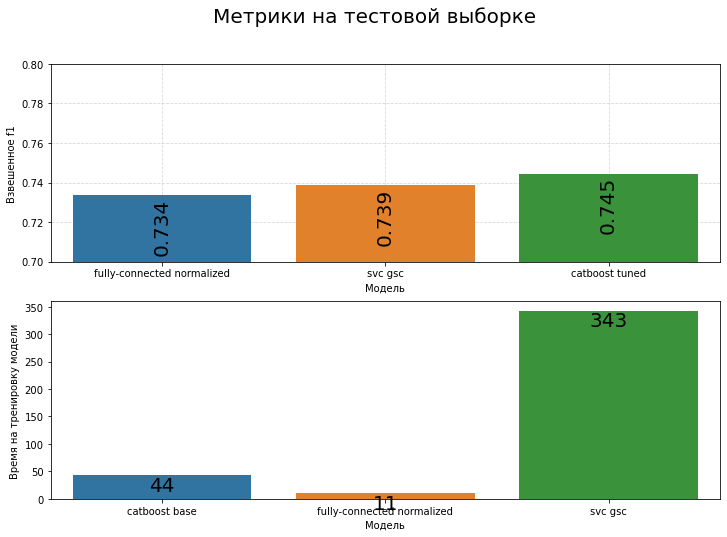

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7, 0.8)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=["catboost base", "fully-connected normalized", "svc gsc"],
    y="training_time",
    data=best_models,
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Самой оптимальной моделью снова становится метод опорных векторов

In [16]:
with open("cross_validation_scores/svc gsc_354.json", "r") as f:
    cv_scores = json.load(f)

svc_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])


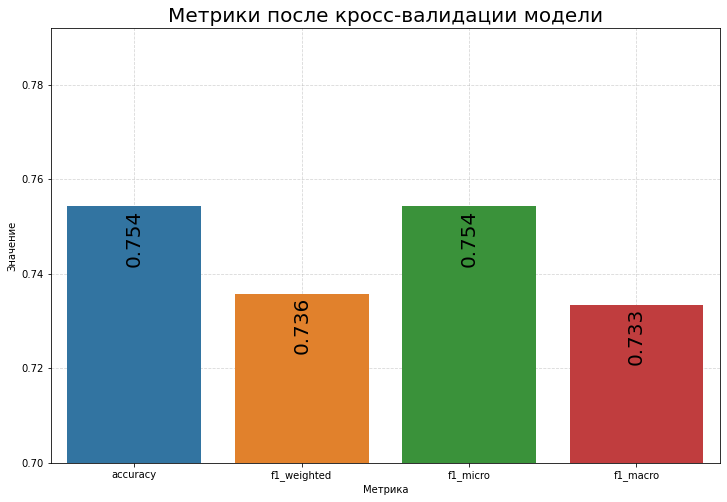

In [17]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=svc_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7)
plt.show()


Метрики кросс-валидации выше, чем метрики на тесте. Значит, что при валидации модели во время подбора параметров была случайно выбрана более "сложная" для модели выборка.

В целом, можно сказать, что при увеличении количества классов, требуется увеличивать и количество аудиофайлов от каждого пользователя, но даже не делая этого, можно достичь хорошего результата. Проверю гипотезу об увеличении качества, при увеличении количества объектов класса.

In [18]:
with open("cross_validation_scores/svc gsc_354_more_data.json", "r") as f:
    cv_scores = json.load(f)

svc_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])


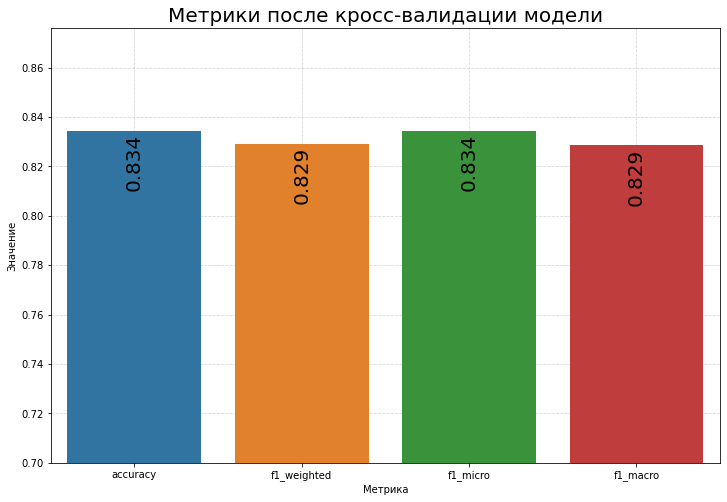

In [19]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=svc_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7)
plt.show()


Как видно из графиков, метрики значительно выросли при увеличении количества объектов, принадлежащих к классу в 2 раза (с 5 объектов на класс, до десяти)

# Модели, обученные на более широком множестве признаков, которые можно получить из аудиоданных

В предыдущем пункте для классификации использовались только мел-кепстральные коэффициенты. Сейчас я буду использовать также:
- хромограмму
- мел-спектрограмму
- тональные центры тяжести

## 102 класса

In [20]:
experiment_name = "102 classes, 5 per class"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    'experiment_id']
cls_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=['metrics.f1_weighted'])
cls_102_5_df = cls_102_5_df.iloc[::-1][
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
    ]
]

cls_102_5_df = cls_102_5_df.sort_values(by='metrics.f1_weighted', ascending=False).iloc[:10, :]
best_models_names = cls_102_5_df['tags.mlflow.runName']

cls_102_5_df = pd.melt(
    cls_102_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.f1_weighted', 'metrics.f1_micro', 'metrics.accuracy'],
    var_name='Metric',
    value_name='Value',
)

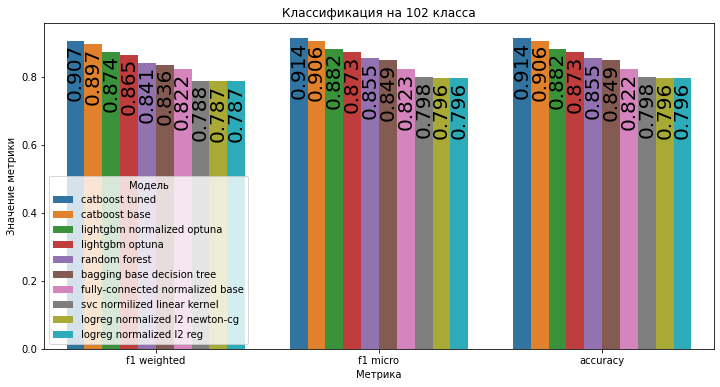

In [21]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value',
                  hue='tags.mlflow.runName', data=cls_102_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['f1 weighted', 'f1 micro', 'accuracy'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
plt.legend(title='Модель', loc='lower left')
bar.set_title('Классификация на 102 класса')
plt.show()

Как видно, преимуществами большого количества признаков смогли воспользоваться только древовидные модели. Посмотрю время, требуемое для обучения той или иной модели и выберу лучшую для проведения кросс-валидации.

In [22]:
cls_102_5_df = mlflow.search_runs([experiment_id], order_by=['metrics.f1_weighted'])
best_models = cls_102_5_df[
    cls_102_5_df['tags.mlflow.runName'].isin(
        best_models_names
    )
]
best_models['training_time'] = (
    best_models['end_time'] - best_models['start_time']
).dt.seconds
best_models = best_models[
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
        'training_time',
    ]
]
best_models = best_models.sort_values(by='metrics.f1_weighted', ascending=False)

C:\Users\Никита\AppData\Local\Temp\ipykernel_18304\2555358958.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['training_time'] = (


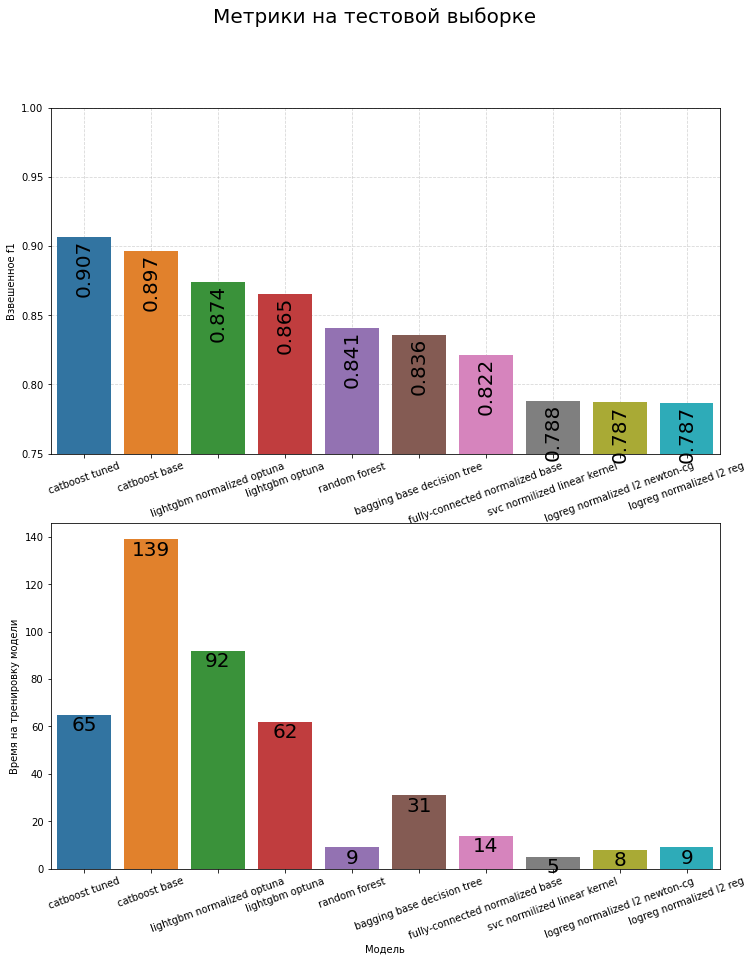

In [23]:
plt.figure(figsize=(12, 14))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.75, 1)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="training_time",
    data=best_models,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Такие образом, катбуст с подобранными гиперпараметрами показывает лучшее качество

In [33]:
with open("cross_validation_scores/catboost tuned_102.json", "r") as f:
    cv_scores = json.load(f)

cb_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])

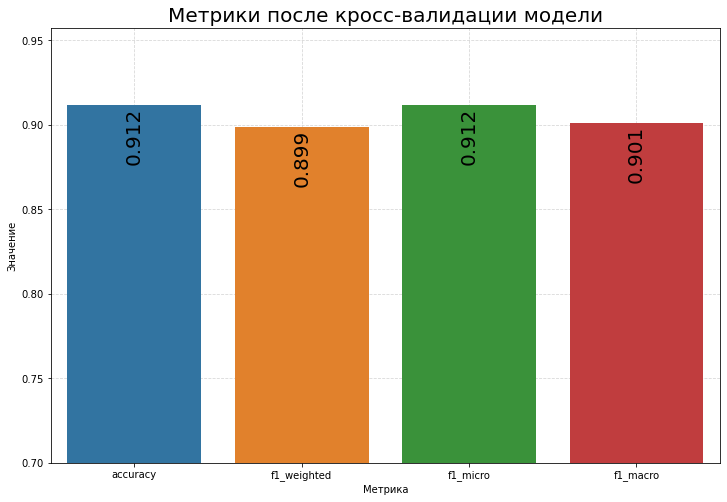

In [34]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=cb_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7)
plt.show()


Значение метрик на кросс-валидации остались теми же, что говорит об отсутствии переобучения, путём подбора гиперпараметров под тестовые данные

## 354 класса

In [35]:
experiment_name = "354 classes, 5 per class"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    'experiment_id']
cls_354_5_df = mlflow.search_runs(
    [experiment_id], order_by=['metrics.f1_weighted'])
cls_354_5_df = cls_354_5_df.iloc[::-1][
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
    ]
]

cls_354_5_df = cls_354_5_df.sort_values(by='metrics.f1_weighted', ascending=False).iloc[:10, :]
best_models_names = cls_354_5_df['tags.mlflow.runName']

cls_354_5_df = pd.melt(
    cls_354_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.f1_weighted', 'metrics.f1_micro', 'metrics.accuracy'],
    var_name='Metric',
    value_name='Value',
)

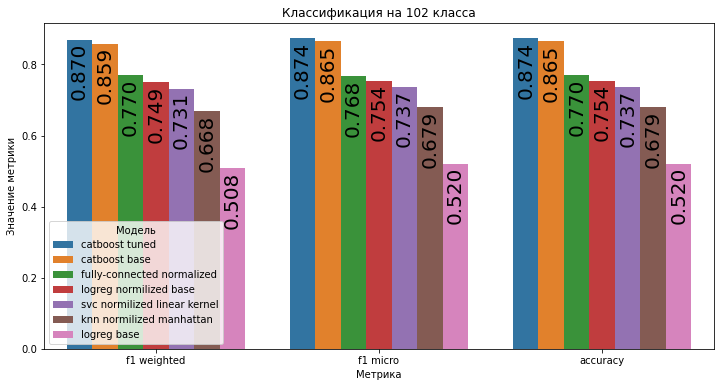

In [36]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value',
                  hue='tags.mlflow.runName', data=cls_354_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['f1 weighted', 'f1 micro', 'accuracy'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
plt.legend(title='Модель', loc='lower left')
bar.set_title('Классификация на 102 класса')
plt.show()

Здесь также лидирует катбуст, причём со значительным отрывом от других моделей.

In [37]:
cls_354_5_df = mlflow.search_runs([experiment_id], order_by=['metrics.f1_weighted'])
best_models = cls_354_5_df[
    cls_354_5_df['tags.mlflow.runName'].isin(
        best_models_names
    )
]
best_models['training_time'] = (
    best_models['end_time'] - best_models['start_time']
).dt.seconds
best_models = best_models[
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
        'training_time',
    ]
]
best_models = best_models.sort_values(by='metrics.f1_weighted', ascending=False)

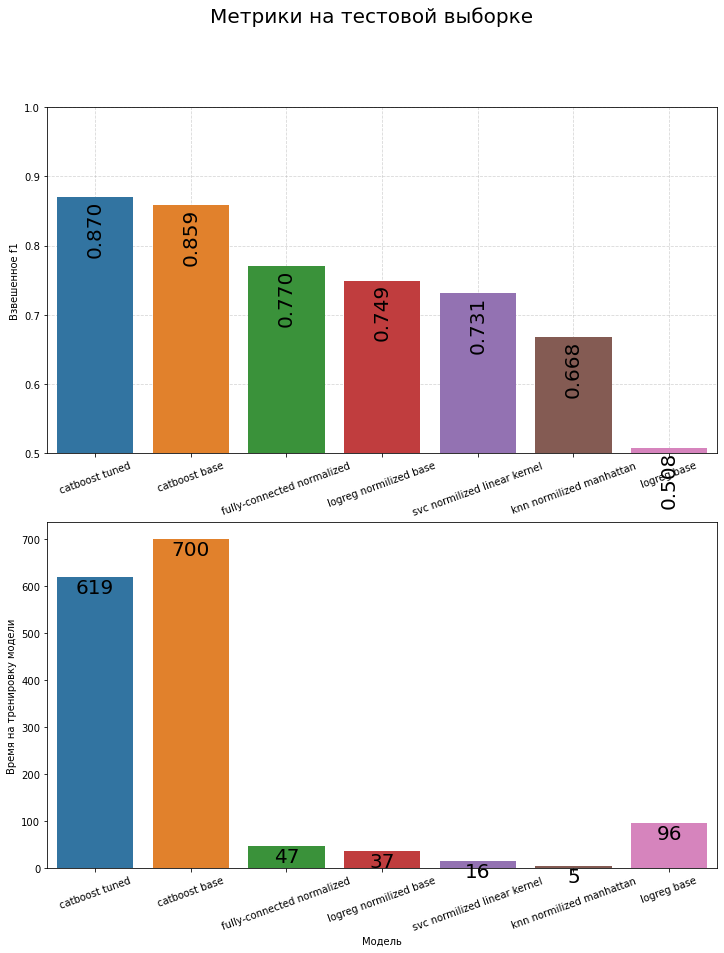

In [42]:
plt.figure(figsize=(12, 14))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.5, 1)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="training_time",
    data=best_models,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Как видно, время на обучение градиентного бустинга значительно превышает время обучения других алгоритмов. Несмотря на это, прирост в качестве также значителен, из-за чего остановлю свой выбор именно на этой модели.